In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import math
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from mamba import *

In [2]:
stock_name = 'PEP'
df = yf.download(stock_name,
                 start='2016-06-01',
                 end='2019-01-26',
                 progress=False)
file_name = f'{stock_name}.csv'
df.to_csv(file_name)

In [3]:
df = pd.read_csv(file_name)
close_prices = df['Close']

In [4]:
print(close_prices.shape)

(668,)


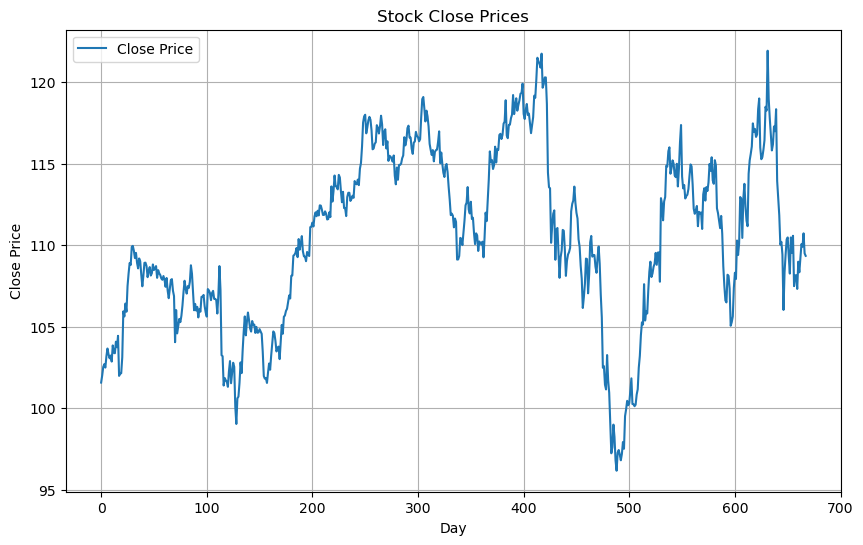

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Close Price')
plt.title('Stock Close Prices')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
pct_changes = close_prices.pct_change().dropna()*100

In [7]:
pct_changes = pct_changes.values.reshape(-1, 1)

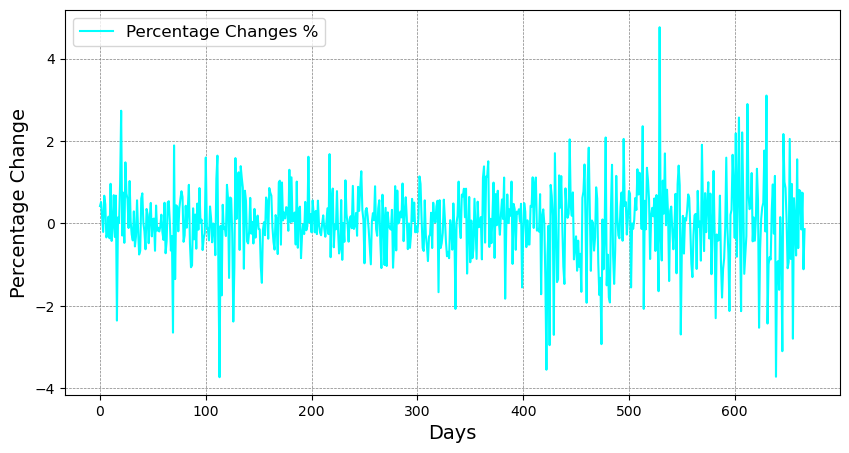

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes %')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray') 
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pct_changes = scaler.fit_transform(pct_changes)

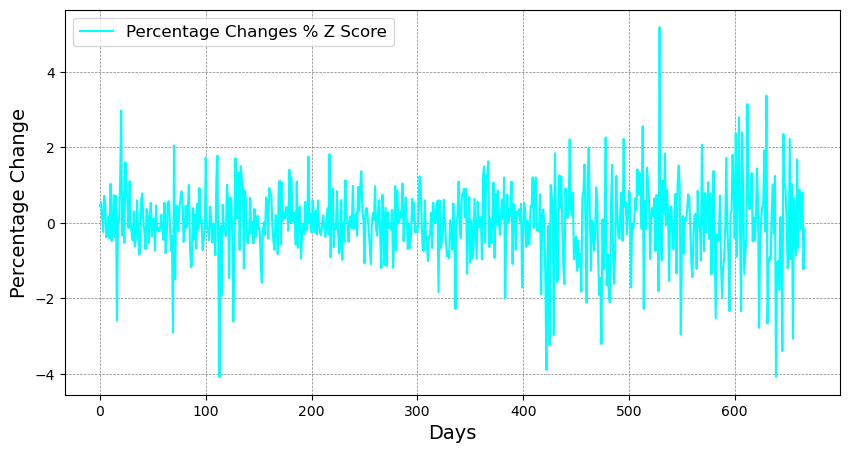

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(pct_changes, color='cyan', label='Percentage Changes % Z Score')
plt.title('', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Days', fontsize=14, color='black')
plt.ylabel('Percentage Change', fontsize=14, color='black')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray') 
plt.show()

In [11]:
print(pct_changes.shape)

(667, 1)


In [12]:
def create_time_series_windows(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset)-time_step):
        historical_data = dataset[i:(i+time_step), 0]
        features.append(historical_data)
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from itertools import product  # For generating combinations

# Define model parameters
learning_rates = [0.0001]
epochs = [25, 30, 20]
time_steps = [10, 15, 20]
batch_sizes = [32]

# Create combinations of parameters (learning rate, epochs, time steps, batch size)
combinations = list(product(learning_rates, epochs, time_steps, batch_sizes))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_size = 120

# Initialize ensemble_results to store the predictions
ensemble_results = []

# Loop over parameter combinations
for lr, epoch_count, time_step, batch_size in combinations:
    print(f"Running model with lr={lr}, epochs={epoch_count}, time_step={time_step}, batch_size={batch_size}")

    # Create different time step dataset
    X, y = create_time_series_windows(pct_changes, time_step)
    training_size = len(X) - test_size
    X_train, X_test = X[0:training_size], X[training_size:]
    y_train, y_test = y[0:training_size], y[training_size:]
    
    # Reshape the data (assuming the scaler is already applied)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    # Create DataLoader with varying batch sizes
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Define Mamba model configuration
    config = MambaConfig(
        d_model=128,
        n_layers=3,
        dt_rank='auto',
        d_state=16,
        expand_factor=2,
        d_conv=4,
        dt_min=0.001,
        dt_max=0.1,
        dt_init="random",
        dt_scale=1.0,
        bias=False,
        conv_bias=True,
        pscan=True
    )
    
    model = Mamba(config)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    # Train the model
    for epoch in range(epoch_count):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            last_outputs = outputs[:, -1, -1]
            loss = criterion(last_outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epoch_count}, Loss: {total_loss / len(train_loader)}")

    # Test mode and prediction
    model.eval()
    X_test_tensor = X_test.clone().detach().to(device).view(-1, time_step, 1)
    
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)[:, -1, -1].cpu().numpy()
        y_test_pred = y_test_pred.reshape(-1, 1)
        y_test_pred = scaler.inverse_transform(y_test_pred)
        y_test_binary_pred = np.where(y_test_pred > 0, 1, 0)
        ensemble_results.append(y_test_binary_pred)

# Convert predictions to a numpy array for further processing
ensemble_results = np.array(ensemble_results)


Running model with lr=0.0001, epochs=25, time_step=10, batch_size=32
Epoch 1/25, Loss: 2.025568955084857
Epoch 2/25, Loss: 1.5464454135474037
Epoch 3/25, Loss: 1.3801679120344275
Epoch 4/25, Loss: 1.4698033543194042
Epoch 5/25, Loss: 1.2926118899794186
Epoch 6/25, Loss: 1.19852914704996
Epoch 7/25, Loss: 1.2900815904140472
Epoch 8/25, Loss: 1.2641042067724115
Epoch 9/25, Loss: 1.1498016346903408
Epoch 10/25, Loss: 1.1395188254468582
Epoch 11/25, Loss: 1.0230771934284884
Epoch 12/25, Loss: 0.9993981385932249
Epoch 13/25, Loss: 0.993225972442066
Epoch 14/25, Loss: 1.0853225729044746
Epoch 15/25, Loss: 0.9576574160772211
Epoch 16/25, Loss: 1.0367269147844875
Epoch 17/25, Loss: 0.9589695281842175
Epoch 18/25, Loss: 1.050907569773057
Epoch 19/25, Loss: 0.9833062834599439
Epoch 20/25, Loss: 1.004458050517475
Epoch 21/25, Loss: 0.963411320658291
Epoch 22/25, Loss: 0.9360115054775687
Epoch 23/25, Loss: 0.9469770841738757
Epoch 24/25, Loss: 0.8996108770370483
Epoch 25/25, Loss: 0.89905450799885

In [14]:
majority_voting_predictions = []

# Iterate through each column (i.e., for each test sample)
for i in range(ensemble_results.shape[1]):  # 120 test samples
    # Get the current column (predictions from all models for this test sample)
    column = ensemble_results[:, i]
    
    # Check if the majority of values in this column are 1 or 0
    if np.sum(column) > len(column) // 2:  # If sum of column is more than half, majority is 1
        majority_voting_predictions.append(1)
    else:
        majority_voting_predictions.append(0)

# Convert the majority voting predictions to a numpy array and reshape it to (120, 1)
majority_voting_predictions = np.array(majority_voting_predictions)

In [15]:
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)
y_test_binary = np.where(y_test > 0, 1, 0)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
# Sonuçları değerlendirme
accuracy = accuracy_score(y_test_binary, majority_voting_predictions)
precision = precision_score(y_test_binary, majority_voting_predictions)
recall = recall_score(y_test_binary, majority_voting_predictions)
balanced_accuracy = balanced_accuracy_score(y_test_binary, majority_voting_predictions)
f1 = f1_score(y_test_binary, majority_voting_predictions)

print(f"Ensemble Accuracy: {accuracy:.2f}")
print(f"Ensemble Precision: {precision:.2f}")
print(f"Ensemble Recall: {recall:.2f}")
print(f"Ensemble Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"Ensemble F1 Score: {f1:.2f}")

Ensemble Accuracy: 0.53
Ensemble Precision: 0.53
Ensemble Recall: 0.55
Ensemble Balanced Accuracy: 0.53
Ensemble F1 Score: 0.54


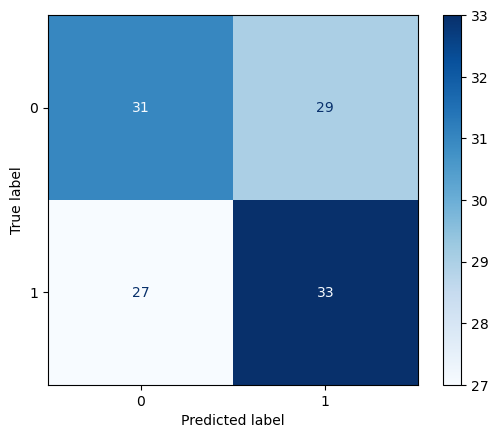

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_binary, majority_voting_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

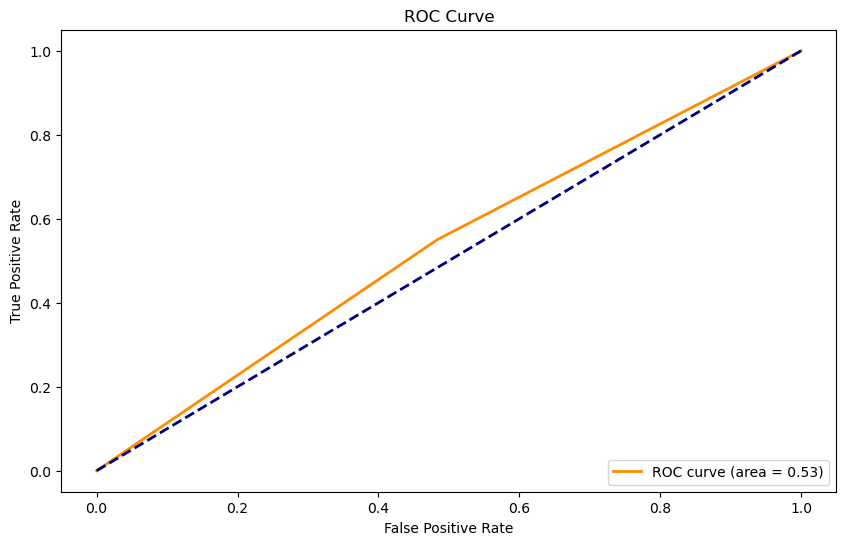

In [18]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test_binary, majority_voting_predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

financial eval

In [19]:
df = df.drop(index=0)
df = df.drop(['High', 'Low', 'Volume', 'Adj Close'], axis=1)
predicted_stock_price_binary = majority_voting_predictions.flatten()
df.loc[len(df) - len(predicted_stock_price_binary) + 1:len(df), 'y_test_pred_binary'] = predicted_stock_price_binary
new_df = df[['Date', 'Open', 'Close','y_test_pred_binary']].copy()
df = new_df.tail(len(predicted_stock_price_binary))
df = df.reset_index(drop=True)

In [20]:
pd.set_option('display.max_rows', None)  # Tüm satırları göster
pd.set_option('display.max_columns', None)  # Tüm sütunları göster
pd.set_option('display.max_colwidth', None)  # Sütun genişliğini sınırlama
# Yeni bir sütun oluştur ve başlangıçta boş bırak
df['signal'] = ''

# İlk elemanı kontrol et
if df['y_test_pred_binary'].iloc[0] == 1:
    df.at[0, 'signal'] = 'al'
elif df['y_test_pred_binary'].iloc[0] == 0:
    df.at[0, 'signal'] = 'sat'

# Daha sonraki elemanları kontrol et
for i in range(1, len(df)):
    if df['y_test_pred_binary'].iloc[i] != df['y_test_pred_binary'].iloc[i - 1]:
        if df['y_test_pred_binary'].iloc[i] == 1:
            df.at[i, 'signal'] = 'al'
        elif df['y_test_pred_binary'].iloc[i] == 0:
            df.at[i, 'signal'] = 'sat'
    else:
        df.at[i, 'signal'] = ''


In [21]:
ana_para = 10000
hisse_adedi = 0
islem_sayisi = 0

# Yeni sütunları tutacak listeler
yeni_para_list = []
yeni_hisse_list = []

for index, row in df.iterrows():
    sinyal = row['signal']
    acilis_fiyati = row['Open']

    if sinyal == 'al':
        hisse_adedi = ana_para // acilis_fiyati
        ana_para -= hisse_adedi * acilis_fiyati
        islem_sayisi += 1
    elif sinyal == 'sat' and hisse_adedi > 0:
        ana_para += hisse_adedi * acilis_fiyati
        hisse_adedi = 0
        islem_sayisi += 1

    # Yeni işlem sonuçlarını listelere ekle
    yeni_para_list.append(ana_para)
    yeni_hisse_list.append(hisse_adedi)

# Yeni sütunları DataFrame'e ekle
df['Yeni_Para'] = yeni_para_list
df['Yeni_Hisse'] = yeni_hisse_list

print("yeni para")
son_ana_para = df.loc[len(df) - 1, 'Yeni_Para']
print(son_ana_para)
yeni_hisse = df.loc[len(df) - 1, 'Yeni_Hisse']
print("yeni hisse")
print(yeni_hisse )
son_kapanis = df.loc[len(df) - 1, 'Close']
print("son_kapanis")
print(son_kapanis)
toplam_getiri = son_kapanis*yeni_hisse+son_ana_para
print("toplam getiri")
print(toplam_getiri)

yeni para
4.2810516357330926
yeni hisse
93.0
son_kapanis
109.3499984741211
toplam getiri
10173.830909728995


In [22]:
# İlk satırdaki fiyatla hisse al
ilk_acilis = df.loc[0, 'Open']
ana_para = 10000
hisse_adedi = ana_para // ilk_acilis
ana_para = ana_para-hisse_adedi*ilk_acilis


son_kapanis = df.loc[len(df) - 1, 'Close']
ana_para += hisse_adedi * son_kapanis

print("son_kapanis")
print(son_kapanis)

# Sonucu print et
print(f"Buy and Hold: Ana Para = {ana_para}")

son_kapanis
109.3499984741211
Buy and Hold: Ana Para = 9528.460159301758


In [ ]:
import os
pid = os.getpid()
!kill -9 $pid